<a href="https://colab.research.google.com/github/hiydavid/tfdev_learning/blob/main/ZTM/notebooks/tfdev_05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning Fine Tuning

In this notebook we'll:

* Introducing transfer learning fine-tuning
* Introduce the Keras functional API
* Use a small dataset to experiment faster
* Data augmentation
* Running a series of experiments on our Food Vision data
* Introduce the ModelCheckpoint callback to save intermediate training results

# Import Helper Functions

In [1]:
# get prebuilt helper function 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-30 23:00:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-30 23:00:50 (33.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# import helper functions
from helper_functions import (
    create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
)

# Get Data

In [3]:
# get data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-03-30 23:00:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.251.120.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   178MB/s    in 0.9s    

2022-03-30 23:00:57 (178 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# check out how many images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [5]:
# create training / testing paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
# load data using image_dataset_from_directory
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# check output, see that it is batches of data
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# check class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# check 1 sample from 1 batch
for images, labels in train_data_10_percent.take(1):
    print(images[0], labels[0])

tf.Tensor(
[[[ 74.44547     55.445473    23.21875   ]
  [ 72.09662     53.424107    19.441645  ]
  [ 84.17347     66.17347     28.02232   ]
  ...
  [ 11.43334      6.4333405    2.4333403 ]
  [ 10.306433     5.3064327    1.3064328 ]
  [ 10.058036     5.058036     1.0580359 ]]

 [[ 75.24713     55.24713     20.845345  ]
  [ 74.25989     54.259888    19.143812  ]
  [ 82.7921      63.05198     25.24745   ]
  ...
  [  8.785736     4.785736     1.7857361 ]
  [ 10.937818     6.937818     3.937818  ]
  [ 10.410679     6.410679     3.431408  ]]

 [[ 71.68813     50.161354    12.348852  ]
  [ 76.41773     54.890945    16.364159  ]
  [ 87.286354    66.48692     25.458546  ]
  ...
  [  5.7321644    4.022343     0.42251778]
  [  6.8749866    5.1651654    1.4017725 ]
  [  4.3526435    2.6428223    0.        ]]

 ...

 [[101.370224    74.370224     3.3702261 ]
  [102.3517      75.3517       4.4231277 ]
  [101.34406     74.986916     3.7726316 ]
  ...
  [  0.7633667    2.7126646    0.        ]
  [  0.

# Build Model with Functional API

In [10]:
# build functional API with keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# freeze the base model
base_model.trainable = False

# create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# pass the input
x = base_model(inputs)

# average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)), 
    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")]
)

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220330-230108
Epoch 1/5
24/24 [==============================] - 28s 455ms/step - loss: 1.8762 - accuracy: 0.4267 - val_loss: 1.3523 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 9s 361ms/step - loss: 1.1421 - accuracy: 0.7600 - val_loss: 0.9516 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - 9s 358ms/step - loss: 0.8342 - accuracy: 0.8053 - val_loss: 0.7823 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 9s 358ms/step - loss: 0.6772 - accuracy: 0.8533 - val_loss: 0.6981 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 7s 269ms/step - loss: 0.5988 - accuracy: 0.8733 - val_loss: 0.6482 - val_accuracy: 0.8257


In [11]:
# evaluate
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 137ms/step - loss: 0.6067 - accuracy: 0.8416


[0.6067355871200562, 0.8416000008583069]

In [12]:
# check layers and name
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# view base model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
# summary of model_0
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


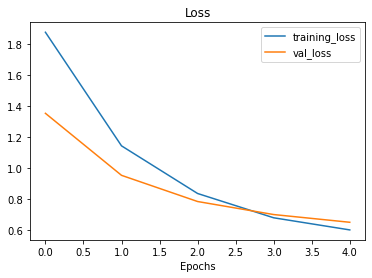

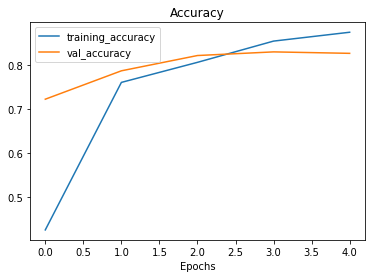

In [15]:
# check training curves
plot_loss_curves(history_10_percent)

# Getting a Feature Vector From a Trained Model

In [16]:
# define input shape
input_shape = (1, 4, 4, 3)

In [17]:
# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [19]:
# pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor.numpy()

array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)

In [35]:
# manually average the input tensor across the middle 2 axes (1 and 2)
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>